![poster](./취업춘배.jpg)

# 😸 <b>공겹춘배</b>

알리오
https://alio.go.kr/

잡알리오
https://job.alio.go.kr/

잡플래닛
https://www.jobplanet.co.kr/

## 📚 <b>라이브러리</b>

In [31]:
from bs4 import BeautifulSoup
import requests
import time
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# from selenium import webdriver
# from selenium.webdriver import ActionChains
# from selenium.webdriver.common.keys import Keys
# from selenium.webdriver.common.by import By

#한글 폰트
if platform.system()== 'Windows' :
    plt.rc('font', family='NanumGothic')
else:
    plt.rc('font', family = 'AppleGothic')

## 🛠 <b>알리오 공공기관 코드 크롤링</b>


알리오 370여개 공공기관 스크립트 작동 내부 url 코드 크롤링


알리오 - [항목 별 공시] - [직원 평균보수 현황] 정보는 문서 스크립트로 동작, 바로 크롤링 할 수 없음.


각 공공기관 별 내부 url 코드에서 규칙을 찾아 크롤링 (C0001 ~ C1370)


+ https://alio.go.kr/item/itemReportTerm.do?apbaId=C0001&reportFormRootNo=20601#toc-124


script 에 disclosureNo('2021041302190478') 형식의 공개 번호 발견, html 문서에 직접 접근해 크롤링 할 수 있게 됨.


+ https://alio.go.kr/upload/disclosure/2021/04/13/2021041302190478/doc.html

In [ ]:
# 알리오 372개 공공기관 내부 url 코드 크롤링 (7분 40초 걸림)

codedict = {"institution":[], "code":[]}

for i in range(1, 1370):
    
    if i < 10 :
        urlcode = 'C000{}'.format(i)
    elif 10 <= i | i < 100 :
        urlcode = 'C00{}'.format(i)
    elif 100 <= i | i < 1000 :
        urlcode = 'C0{}'.format(i)
    elif 1000 <= i | i < 10000 :
        urlcode = 'C{}'.format(i)

    url = 'https://alio.go.kr/item/itemReportTerm.do?apbaId={}&reportFormRootNo=20601'.format(urlcode)

    response = requests.get(url)
    response.raise_for_status()

    if response.status_code == 200:
        html = response.text
        soup = BeautifulSoup(html, 'html.parser')
        #print(response.status_code)
    else :
        print(response.status_code)

    institution = soup.select_one('#p_header_wrap > div.hl_area > div > div > span')

    if institution != None:
        codedict['institution'].append(institution.text)
        codedict['code'].append(urlcode)
        print('institution: ' + institution.text + ', code: ' + urlcode)

    i+=1


### 추출한 url 코드 저장

In [ ]:
df = pd.DataFrame(codedict)
df

# 한국광해광업공단(2021.12.08 지정) 이전 데이터 없음 -> 삭제
# **한국율도 데이터 없음 -> 삭제
df.drop(index=226, axis=0, inplace=True)
df.drop(index=371, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

# csv 파일로 저장
df.to_csv('institution_code.csv', index=False)

# 제대로 저장되었는지 확인
institution_code = pd.read_csv('institution_code.csv')
institution_code

In [33]:

institution_code = pd.read_csv('institution_code.csv')
institution_code
institution_code[institution_code['institution']=='**한국율도']

institution_code.drop(index=226, axis=0, inplace=True)
institution_code.drop(index=371, axis=0, inplace=True)
institution_code.reset_index(drop=True, inplace=True)
institution_code

,institution,code
0,88관광개발(주),C0001
1,가축위생방역지원본부,C0002
2,강릉원주대학교치과병원,C0003
3,강원대학교병원,C0004
4,(주)강원랜드,C0005
...,...,...
365,공간정보품질관리원,C1327
366,차세대수치예보모델개발사업단,C1330
367,국립해양과학관,C1333
368,국립호남권생물자원관,C1334


## 🛠 <b>알리오 정보 크롤링</b>
disclosureNo('2021041302190478') 형식의 공개 번호를 통해 알리오 html 문서 크롤링 

https://alio.go.kr/upload/disclosure/2021/04/13/2021041302190478/doc.html

+ 신입사원 초임 (new_sal)
+ 직원 평균연봉 (avg_sal)
+ 평균 근속연수 (y_service)
>각각 6년치 데이터 크롤링(2016, 2017, 2018, 2019, 2020, 2021)

In [35]:
class GetAlioInfo :
    
    def __init__(self, keyword) :
        urlword = institution_code[institution_code['institution']==keyword]['code'].values[0]

        url = 'https://alio.go.kr/item/itemReportTerm.do?apbaId={}&reportFormRootNo=20601'.format(urlword)

        response = requests.get(url)
        response.raise_for_status()

        html = response.text
        self.soup = BeautifulSoup(html, 'html.parser')

        script = self.soup.select("body > script:nth-child(4)")
        str(script[0])
        regex=re.compile("disclosureNo:\"(\d+)\"")
        disclosureNo = regex.findall(str(script[0]))[0]
        disclosureyear = disclosureNo[:4]
        disclosuremonth = disclosureNo[4:6]
        disclosureday = disclosureNo[6:8]

        url = 'https://alio.go.kr/upload/disclosure/{}/{}/{}/{}/doc.html'.format(disclosureyear, disclosuremonth, disclosureday, disclosureNo)

        response = requests.get(url)
        response.raise_for_status()

        if response.status_code == 200:
            html = response.text
            self.soup = BeautifulSoup(html, 'html.parser')
            #print(response.status_code)
        else :
            print(response.status_code)
    
    def get_new_sal(self) :
        address = self.soup.find("a", text="2. 신입사원 초임").findNext(text="합계").parent.parent
        new_sal = address.text.strip().split('\n')
        new_sal[0] = '신입사원 초봉'
        return(new_sal)

    def get_avg_sal(self) :
        address = self.soup.find("td", text="정규직(일반정규직)").findNext(text="1인당 평균 보수액").parent.parent
        avg_sal = address.text.strip().split('\n')
        return(avg_sal)

    def get_y_service(self) :
        address = self.soup.find("td", text="정규직(일반정규직)").findNext(text="평균근속연수(개월)").parent.parent
        y_service = address.text.strip().split('\n')
        return(y_service)


### 알리오 직원 평균연봉 크롤링+저장
직원 평균연봉(avg_sal) -> alio_avg_sal.csv

In [36]:
avg_sal_dict = {"institution":[], "avg16":[], "avg17":[], "avg18":[], "avg19":[], "avg20":[], "avg21":[]}

i = 1
for keyword in institution_code['institution']:
    a = GetAlioInfo(keyword)
    templist = a.get_avg_sal()
    avg_sal_dict['institution'].append(keyword)
    avg_sal_dict['avg16'].append(templist[1].strip().replace(',',''))
    avg_sal_dict['avg17'].append(templist[2].strip().replace(',',''))
    avg_sal_dict['avg18'].append(templist[3].strip().replace(',',''))
    avg_sal_dict['avg19'].append(templist[4].strip().replace(',',''))
    avg_sal_dict['avg20'].append(templist[5].strip().replace(',',''))
    avg_sal_dict['avg21'].append(templist[6].strip().replace(',',''))
    percentage = round(i / (len(institution_code['institution'])+1) * 100, 2)
    print(percentage,'% ', keyword, templist[1:6])
    i += 1

df = pd.DataFrame(avg_sal_dict)
df.to_csv('alio_avg_sal.csv', index=False)
df

0.27 %  88관광개발(주) ['56,434', '58,444', '61,300', '62,344', '62,676']
0.54 %  가축위생방역지원본부 ['59,728', '60,088', '60,792', '66,621', '66,239']
0.81 %  강릉원주대학교치과병원 ['40350', '40702', '44002', '43493', '44497']
1.08 %  강원대학교병원 ['53,353 ', '56,462 ', '56,812 ', '57,291 ', '55,816 ']
1.35 %  (주)강원랜드 ['69,641', '71,281', '72,554', '74,294', '70,676']
1.62 %  건강보험심사평가원 ['60,998', '63,280', '63,923', '63,608', '65,538']
1.89 %  경북대학교병원 ['62,133', '64,124', '65,399', '65,945', '67,373']
2.16 %  경상국립대학교병원 ['61,674', '60,656', '62,494', '61,918', '62,575']
2.43 %  경제인문사회연구회 ['59,532', '58,670', '58,671', '59,353', '62,227']
2.7 %  공무원연금공단 ['72,354', '71,861', '69,113', '69,821', '70,735']
2.96 %  과학기술정책연구원 ['68,435', '71,457', '72,520', '63,271', '68,133']
3.23 %  광주과학기술원 ['98,404', '99,155', '101,614', '105,269', '108,266']
3.5 %  한국교통안전공단 ['73,533', '72,393', '72,528', '73,904', '75,295']
3.77 %  한국원자력통제기술원 ['74,084', '73,480', '78,667', '77,991', '78,568']
4.04 %  국립공원공단 ['52,506', '54,464', '55,

,institution,avg16,avg17,avg18,avg19,avg20,avg21
0,88관광개발(주),56434,58444,61300,62344,62676,62676
1,가축위생방역지원본부,59728,60088,60792,66621,66239,63474
2,강릉원주대학교치과병원,40350,40702,44002,43493,44497,45365
3,강원대학교병원,53353,56462,56812,57291,55816,56482
4,(주)강원랜드,69641,71281,72554,74294,70676,76621
...,...,...,...,...,...,...,...
365,공간정보품질관리원,0,0,0,0,63405,66282
366,차세대수치예보모델개발사업단,0,0,0,0,67764,79305
367,국립해양과학관,0,0,0,0,64113,66741
368,국립호남권생물자원관,0,0,0,0,83731,58512


### 알리오 신입사원 초봉 크롤링+저장
신입사원 초봉(new_sal) -> alio_new_sal.csv

In [37]:
new_sal_dict = {"institution":[], "new16":[], "new17":[], "new18":[], "new19":[], "new20":[], "new21":[]}

i = 1
for keyword in institution_code['institution']:
    a = GetAlioInfo(keyword)
    templist = a.get_new_sal()
    new_sal_dict['institution'].append(keyword)
    new_sal_dict['new16'].append(templist[1].strip().replace(',',''))
    new_sal_dict['new17'].append(templist[2].strip().replace(',',''))
    new_sal_dict['new18'].append(templist[3].strip().replace(',',''))
    new_sal_dict['new19'].append(templist[4].strip().replace(',',''))
    new_sal_dict['new20'].append(templist[5].strip().replace(',',''))
    new_sal_dict['new21'].append(templist[6].strip().replace(',',''))
    percentage = round(i / (len(institution_code['institution'])+1) * 100, 2)
    print(percentage,'% ', keyword, templist[1:6])
    i += 1
    
df = pd.DataFrame(new_sal_dict)
df.to_csv('alio_new_sal.csv', index=False)
df

0.27 %  88관광개발(주) ['25,892', '32,975', '34,678', '35,143', '35,075']
0.54 %  가축위생방역지원본부 ['25,544', '26,062', '26,384', '27,241', '27,280']
0.81 %  강릉원주대학교치과병원 ['19381', '19790', '20506', '22513', '23160']
1.08 %  강원대학교병원 ['26,909 ', '27,900 ', '28,228 ', '28,977 ', '30,094 ']
1.35 %  (주)강원랜드 ['37,628', '34,628', '37,765', '38,939', '36,740']
1.62 %  건강보험심사평가원 ['34,411', '36,025', '34,693', '35,930', '37,932']
1.89 %  경북대학교병원 ['32,239', '33,769', '36,267', '35,321', '35,497']
2.16 %  경상국립대학교병원 ['31,523', '33,118', '33,070', '33,860', '34,765']
2.43 %  경제인문사회연구회 ['33,458', '34,487', '34,680', '36,680', '37,118']
2.7 %  공무원연금공단 ['34,509', '33,097', '33,507', '34,233', '34,023']
2.96 %  과학기술정책연구원 ['30,668', '33,832', '34,240', '34,240', '34,488']
3.23 %  광주과학기술원 ['37,020', '38,532', '39,872', '41,075', '41,040']
3.5 %  한국교통안전공단 ['36,104', '36,913', '37,157', '38,125', '39,986']
3.77 %  한국원자력통제기술원 ['41,882', '42,833', '45,115', '46,030', '48,858']
4.04 %  국립공원공단 ['29,957', '32,613', '32,563

,institution,new16,new17,new18,new19,new20,new21
0,88관광개발(주),25892,32975,34678,35143,35075,35075
1,가축위생방역지원본부,25544,26062,26384,27241,27280,27015
2,강릉원주대학교치과병원,19381,19790,20506,22513,23160,23494
3,강원대학교병원,26909,27900,28228,28977,30094,30365
4,(주)강원랜드,37628,34628,37765,38939,36740,39941
...,...,...,...,...,...,...,...
365,공간정보품질관리원,0,0,0,0,34252,35003
366,차세대수치예보모델개발사업단,0,0,0,0,33000,38490
367,국립해양과학관,0,0,0,0,43830,49510
368,국립호남권생물자원관,0,0,0,0,0,42305


### 알리오 평균 근속년수 크롤링+저장
평균 근속년수(y_service) -> alio_y_service.csv

In [38]:
y_service_dict = {"institution":[], "ser16":[], "ser17":[], "ser18":[], "ser19":[], "ser20":[], "ser21":[]}

i = 1
for keyword in institution_code['institution']:
    a = GetAlioInfo(keyword)
    templist = a.get_y_service()
    y_service_dict['institution'].append(keyword)
    y_service_dict['ser16'].append(templist[1].strip().replace(',',''))
    y_service_dict['ser17'].append(templist[2].strip().replace(',',''))
    y_service_dict['ser18'].append(templist[3].strip().replace(',',''))
    y_service_dict['ser19'].append(templist[4].strip().replace(',',''))
    y_service_dict['ser20'].append(templist[5].strip().replace(',',''))
    y_service_dict['ser21'].append(templist[6].strip().replace(',',''))
    percentage = round(i / (len(institution_code['institution'])+1) * 100, 2)
    print(percentage,'% ', keyword, templist[1:6])
    i += 1

df = pd.DataFrame(y_service_dict)
df.to_csv('alio_y_service.csv', index=False)
df
    

0.27 %  88관광개발(주) ['18', '17.84', '21.40', '19.27', '234']
0.54 %  가축위생방역지원본부 ['99', '99', '101', '116', '128']
0.81 %  강릉원주대학교치과병원 ['12', '12', '11', '110.88', '111.97']
1.08 %  강원대학교병원 ['96 ', '90 ', '83 ', '82 ', '80 ']
1.35 %  (주)강원랜드 ['126', '133', '149', '157', '164']
1.62 %  건강보험심사평가원 ['137', '133', '131', '122', '127']
1.89 %  경북대학교병원 ['147', '153', '141', '152', '138']
2.16 %  경상국립대학교병원 ['160', '147', '144', '139', '141']
2.43 %  경제인문사회연구회 ['65', '69', '79', '88', '88']
2.7 %  공무원연금공단 ['202', '196', '191', '189', '178']
2.96 %  과학기술정책연구원 ['133', '145', '141', '102', '105']
3.23 %  광주과학기술원 ['125.5', '124.4', '131.5', '141.4', '146']
3.5 %  한국교통안전공단 ['188', '187', '180', '171', '168']
3.77 %  한국원자력통제기술원 ['88.32', '93.22', '100.60', '103.08', '109.75']
4.04 %  국립공원공단 ['145', '147', '155', '148', '143']
4.31 %  국립암센터 ['100', '104', '106', '107', '110']
4.58 %  국민건강보험공단 ['231', '218', '215', '204', '194']
4.85 %  국민연금공단 ['168', '171', '171', '167', '170']
5.12 %  서울올림픽기념국민체육진흥공단 ['

,institution,ser16,ser17,ser18,ser19,ser20,ser21
0,88관광개발(주),18,17.84,21.40,19.27,234,234
1,가축위생방역지원본부,99,99,101,116,128,139
2,강릉원주대학교치과병원,12,12,11,110.88,111.97,123.97
3,강원대학교병원,96,90,83,82,80,0
4,(주)강원랜드,126,133,149,157,164,167
...,...,...,...,...,...,...,...
365,공간정보품질관리원,0,0,0,0,11,23
366,차세대수치예보모델개발사업단,0,0,0,0,1,4
367,국립해양과학관,0,0,0,0,7,15
368,국립호남권생물자원관,0,0,0,0,4.00,10.86


In [39]:
dictionary = {"institution":[], "rate":[]}
i=1
for keyword in institution_code['institution']:
    dictionary['institution'].append(keyword)
    try:
        keyword = keyword.replace('재단법인', '(재)')
        url = 'https://www.jobplanet.co.kr/search?_rs_act=search_history&_rs_con=seach&category=search_new&query={}'.format(keyword)

        response = requests.get(url)

        response.raise_for_status()
        if response.status_code == 200:
            html = response.text
            soup = BeautifulSoup(html, 'html.parser')
            #print(response.status_code)
        else :
            print(response.status_code)

        result_card = soup.select_one('#mainContents > div:nth-child(1) > div > div.result_company_card > div.is_company_card > div:nth-child(1)')
        rate = result_card.select_one('#mainContents > div:nth-child(1) > div > div.result_company_card > div.is_company_card > div:nth-child(1) > span.rate_ty02')
        dictionary['rate'].append(float(rate.text.strip()))
        percentage = round(i / (len(institution_code['institution'])+1) * 100, 2)
        print(percentage,'% ', keyword, ',' ,rate.text)
    except:
        dictionary['rate'].append(None)
        print(percentage,'% ', keyword, ', None')
    i+=1


0.27 %  88관광개발(주) , 3.0
0.54 %  가축위생방역지원본부 , 2.5
0.81 %  강릉원주대학교치과병원 , 0.0
1.08 %  강원대학교병원 , 3.1
1.35 %  (주)강원랜드 , 3.5
1.62 %  건강보험심사평가원 , 3.6
1.89 %  경북대학교병원 , 3.4
2.16 %  경상국립대학교병원 , 3.0
2.43 %  경제인문사회연구회 , 3.0
2.7 %  공무원연금공단 , 2.9
2.96 %  과학기술정책연구원 , 2.8
3.23 %  광주과학기술원 , 3.6
3.5 %  한국교통안전공단 , 3.5
3.77 %  한국원자력통제기술원 , 3.4
4.04 %  국립공원공단 , 2.8
4.31 %  국립암센터 , 2.5
4.58 %  국민건강보험공단 , 3.9
4.85 %  국민연금공단 , 3.9
5.12 %  서울올림픽기념국민체육진흥공단 , 3.9
5.39 %  국제방송교류재단 , 2.7
5.66 %  국토연구원 , 3.1
5.93 %  근로복지공단 , 3.3
6.2 %  기술보증기금 , 4.1
6.47 %  한국남동발전(주) , 4.3
6.74 %  한국남부발전(주) , 4.1
7.01 %  한국농수산식품유통공사 , 4.0
7.28 %  한국농어촌공사 , 3.5
7.55 %  대구경북과학기술원 , 3.4
7.82 %  연구개발특구진흥재단 , 2.1
8.09 %  대외경제정책연구원 , 3.7
8.09 %  한국광물자원공사(2021.09.10. 해산) , None
8.63 %  대한무역투자진흥공사 , 3.6
8.89 %  대한법률구조공단 , 3.4
9.16 %  대한석탄공사 , 2.8
9.43 %  대한적십자사 , 2.4
9.7 %  주택도시보증공사 , 3.9
9.97 %  한국국토정보공사 , 3.6
10.24 %  대한체육회 , 3.1
10.51 %  도로교통공단 , 3.5
10.78 %  독립기념관 , 2.4
11.05 %  한국동서발전(주) , 4.1
11.32 %  한국고전번역원 , 3.0
11.59 %  민주화운동기념사업

In [40]:
df = pd.DataFrame(dictionary)
df.to_csv('jobplanet_rate.csv', index=False)

In [41]:
avg_sal = pd.read_csv('alio_avg_sal.csv')
new_sal = pd.read_csv('alio_new_sal.csv')
y_service = pd.read_csv('alio_y_service.csv')
job_rate = pd.read_csv('jobplanet_rate.csv')

In [56]:
joined_df = pd.merge(avg_sal, new_sal, how='inner', on='institution')
joined_df = pd.merge(joined_df, job_rate, how='inner', on='institution')
joined_df = pd.merge(joined_df, y_service, how='inner', on='institution')

In [78]:
def show_top_num(num):
    standard = input()
    if standard == '연봉':
        standard = 'avg21'
    elif standard == '초봉':
        standard = 'new21'
    elif standard == '평점':
        standard = 'rate'
    elif standard == '근속':
        standard = 'ser21'

    joined_df_top = joined_df.sort_values([standard], ascending=False).head(num)
    
    plt.rc('font', size=13)
    plt.figure(figsize=(20, 10))

    x = np.arange(len(joined_df_top['institution']))

    plt.bar(x-0.3, joined_df_top['rate']*10000, label='rate', color = 'b', width=0.2)
    plt.bar(x-0.1, joined_df_top['new21'], label='new_sal', color = 'r', width=0.2)
    plt.bar(x+0.1, joined_df_top['avg21'], label='avg_sal', color = 'g', width=0.2)
    plt.bar(x+0.3, joined_df_top['ser21']*100, label='ser21', color = 'y', width=0.2)
    plt.xticks(x, joined_df_top['institution'])
    plt.xlabel('공공기관')
    plt.ylabel('수치')
    plt.legend()
    plt.show()

show_top_num(5)

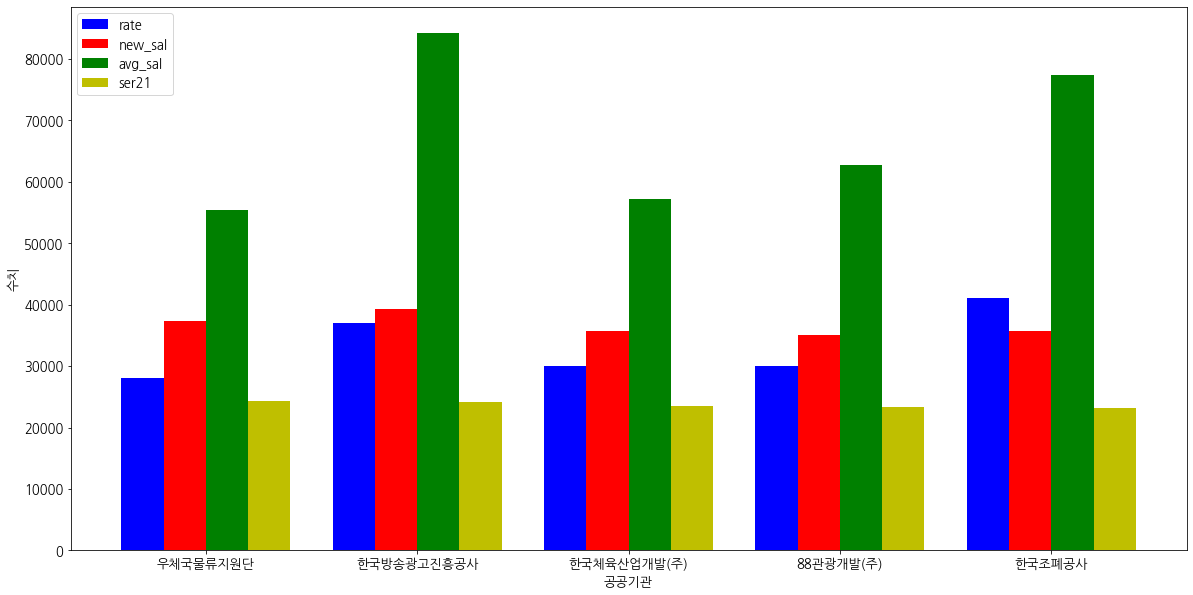

In [105]:
def show_insti_info(keyword):

    df_selected = joined_df[joined_df['institution']==keyword]
    ratio = [df_selected['rate'], df_selected['new21'], df_selected['avg21'], df_selected['ser21']]
    labels = ['별점', '초봉', '연봉', '근속']

    plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops)
    plt.show()

## 🛠<b> 잡알리오 </b>

https://job.alio.go.kr/recruit.do

공공기관 채용 정보 크롤링

In [ ]:
dictionary = {"institution":[], "title":[], "region":[], "type":[], "start_date":[], "end_date":[], "new_sal":[], "avg_sal":[], "rate":[]}

def current_employment():

    classification = input("""
    직종을 선택해 주세요: 
    1. 경영사무,     2. 서비스 ,    3. ICT,    4. 교육/연구,    5. 산업,    6. 전부""")
    if classification == '경영사무':
        classification = '&detail_code=R600001&detail_code=R600002&detail_code=R600003'
    elif classification == '서비스':
        classification = '&detail_code=R600005&detail_code=R600006&detail_code=R600007&detail_code=R600008&detail_code=R600009&detail_code=R600010&detail_code=R600011&detail_code=R600012&detail_code=R600013'
    elif classification == 'ICT':
        classification = '&detail_code=R600019&detail_code=R600020'
    elif classification == '교육/연구':
        classification = '&detail_code=R600004&detail_code=R600025'
    elif classification == '산업':
        classification = '&detail_code=R600014&detail_code=R600015&detail_code=R600016&detail_code=R600017&detail_code=R600018&detail_code=R600021&detail_code=R600022&detail_code=R600023&detail_code=R600024'
    elif classification == '전부':
        classification = ''
    
    page = 1

    while True:

        url = 'https://job.alio.go.kr/recruit.do?pageNo={}&idx=&recruitYear=&recruitMonth={}&work_type=R1010&work_type=R1070&s_date=2021.12.08&e_date=2022.02.08&org_type=&org_name=&ing=2&title=&order=REG_DATE#'.format(page, classification)

        response = requests.get(url)
        response.raise_for_status()

        if response.status_code == 200:
            html = response.text
            soup = BeautifulSoup(html, 'html.parser')
            #print(response.status_code)
        else :
            print(response.status_code)

        tbody = soup.select_one('#frm > table > tbody')
        trs = tbody.select('tr')
        
        if len(tbody.text.strip()) == 0:
            #print('neu~')  # 내용 없는 페이지까지 출력 후 확인용
            break

        for tr in trs:
            tds = tr.select("td")
            dictionary["institution"].append(tds[3].text.replace('재단법인', '(재)').strip())
            dictionary["title"].append(tds[2].text.replace('\t', '').replace('\r', '').replace('\n', '').strip())
            dictionary["region"].append(tds[4].text.replace('\t', '').replace('\r', '').replace('\n', '').strip())
            dictionary["type"].append(tds[5].text.replace('\t', '').replace('\r', '').replace('\n', '').strip())
            dictionary["start_date"].append(tds[6].text)
            dictionary["end_date"].append(tds[7].text)

            # JobPlanet 리뷰
            try:
                keyword = tds[3].text.replace('재단법인', '(재)').strip()
                url = 'https://www.jobplanet.co.kr/search?_rs_act=search_history&_rs_con=seach&category=search_new&query={}'.format(keyword)

                response = requests.get(url)

                response.raise_for_status()
                if response.status_code == 200:
                    html = response.text
                    soup = BeautifulSoup(html, 'html.parser')
                    #print(response.status_code)
                else :
                    print(response.status_code)

                result_card = soup.select_one('#mainContents > div:nth-child(1) > div > div.result_company_card > div.is_company_card > div:nth-child(1)')
                rate = result_card.select_one('#mainContents > div:nth-child(1) > div > div.result_company_card > div.is_company_card > div:nth-child(1) > span.rate_ty02')
                dictionary['rate'].append(float(rate.text.strip()))
                print(rate.text)
            except:
                dictionary['rate'].append(None)
        page += 1

In [ ]:
current_employment()

In [ ]:
df = pd.DataFrame(dictionary)
df

In [ ]:
all_dictionary = {"institution":[], "title":[], "region":[], "type":[], "start_date":[], "end_date":[]}

def get_all_employment():

    classification = input("""
    직종을 선택해 주세요:
    1. 경영사무
    2. 서비스
    3. ICT
    4. 교육/연구 """)
    if classification == '경영사무':
        classification = '&detail_code=R600001&detail_code=R600002&detail_code=R600003'
    elif classification == '서비스':
        classification = '&detail_code=R600005&detail_code=R600006&detail_code=R600007&detail_code=R600008&detail_code=R600009&detail_code=R600010&detail_code=R600011&detail_code=R600012&detail_code=R600013'
    elif classification == 'ICT':
        classification = '&detail_code=R600019&detail_code=R600020'
    elif classification == '교육/연구':
        classification = '&detail_code=R600004&detail_code=R600025'
    elif classification == '산업':
        classification = '&detail_code=R600014&detail_code=R600015&detail_code=R600016&detail_code=R600017&detail_code=R600018&detail_code=R600021&detail_code=R600022&detail_code=R600023&detail_code=R600024'
    page = 1

    while True:

        url = 'https://job.alio.go.kr/recruit.do?pageNo={}&idx=&recruitYear=&recruitMonth={}&work_type=R1010&work_type=R1070&s_date=2016.01.01&e_date=2022.02.08&org_type=&org_name=&title=&order=REG_DATE#'.format(page, classification)

        response = requests.get(url)
        response.raise_for_status()

        if response.status_code == 200:
            html = response.text
            soup = BeautifulSoup(html, 'html.parser')
            #print(response.status_code)
        else :
            print(response.status_code)

        tbody = soup.select_one('#frm > table > tbody')
        trs = tbody.select('tr')
        
        if len(tbody.text.strip()) == 0:
            print('neu~')  # 내용 없는 페이지까지 출력 후 확인용
            break

        for tr in trs:
            tds = tr.select("td")
            all_dictionary["institution"].append(tds[3].text.replace('재단법인', '(재)').strip())
            all_dictionary["title"].append(tds[2].text.replace('\t', '').replace('\r', '').replace('\n', '').strip())
            all_dictionary["region"].append(tds[4].text.replace('\t', '').replace('\r', '').replace('\n', '').strip())
            all_dictionary["type"].append(tds[5].text.replace('\t', '').replace('\r', '').replace('\n', '').strip())
            all_dictionary["start_date"].append(tds[6].text)
            all_dictionary["end_date"].append(tds[7].text)

        page += 1


In [ ]:
get_all_employment()

In [ ]:
df = pd.DataFrame(all_dictionary)
df

In [ ]:
df['start_date'] = pd.to_datetime(df['start_date'], yearfirst= True)
df['end_date'] = pd.to_datetime(df['end_date'], yearfirst= True)

In [ ]:
df

In [ ]:
month = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
monthlist = []


for i in range(1, 13):
    monthlist.append(df[df['end_date'].dt.month==i]['institution'].count())

In [ ]:
monthlist

In [ ]:
import matplotlib.pyplot as plt

import pandas as pd



plt.bar(month, monthlist)

plt.show()

